In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

# Import-uri necesare

In [2]:
import os
import random 
import shutil
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Definim categoriile sub forma unui map:

In [6]:
class_map = {
    'benign': 0,
    'malignant': 1,
    'normal': 2
}

In [7]:
input_base = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"

images_raw = "images_raw"
labels_raw = "labels_raw"

os.makedirs(images_raw, exist_ok=True)
os.makedirs(labels_raw, exist_ok=True)

Creez formatul YOLO cu annotations (bounding box)

In [8]:
for category, class_id in class_map.items():
    input_folder = os.path.join(input_base, category)
    for filename in os.listdir(input_folder):
        if filename.endswith(".png") and "mask" not in filename.lower():
            image_input_path = os.path.join(input_folder, filename)

            # Copy image
            out_img_name = f"{category}_{filename}"
            shutil.copy(image_input_path, os.path.join(images_raw, out_img_name))

            # Create label file
            out_lbl_name = out_img_name.replace(".png", ".txt")
            with open(os.path.join(labels_raw, out_lbl_name), "w") as f:
                f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

Despart in train/val

In [10]:
split_ratio = 0.8
splits = ['train', 'val']

for split in splits:
    os.makedirs(f"images/{split}", exist_ok=True)
    os.makedirs(f"labels/{split}", exist_ok=True)

for category in class_map:
    files = [f for f in os.listdir(images_raw) if f.startswith(category)]
    random.shuffle(files)
    split_point = int(len(files) * split_ratio)
    split_files = {
        'train': files[:split_point],
        'val': files[split_point:]
    }

    for split in splits:
        for file in split_files[split]:
            shutil.copy(os.path.join(images_raw, file), f"images/{split}/{file}")
            label_file = file.replace(".png", ".txt")
            shutil.copy(os.path.join(labels_raw, label_file), f"labels/{split}/{label_file}")

Creez data.yaml

In [11]:
with open("data.yaml", "w") as f:
    f.write("""
path: /kaggle/working
train: images/train
val: images/val

names:
  0: benign
  1: malignant
  2: normal
""")

# 8. Train YOLOv8
model = YOLO("yolov8n.yaml")
model.train(
    data="data.yaml",
    epochs=20,
    imgsz=640,
    batch=8,
    name="breast_ultrasound_model"
)

Ultralytics 8.3.135 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=breast_ultrasound_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

100%|██████████| 755k/755k [00:00<00:00, 17.8MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2897.7±1634.2 MB/s, size: 288.6 KB)


train: Scanning /kaggle/working/labels/train... 623 images, 0 backgrounds, 0 corrupt: 100%|██████████| 623/623 [00:01<00:00, 445.20it/s]

train: New cache created: /kaggle/working/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1533.2±1295.7 MB/s, size: 343.6 KB)


val: Scanning /kaggle/working/labels/val... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<00:00, 450.94it/s]

val: New cache created: /kaggle/working/labels/val.cache


Plotting labels to runs/detect/breast_ultrasound_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/breast_ultrasound_model
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.08G      2.865      3.487       4.07         22        640: 100%|██████████| 78/78 [00:09<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        157        157    0.00512          1      0.222     0.0682

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.51G       2.47      3.173      3.482         23        640: 100%|██████████| 78/78 [00:07<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.45it/s]

                   all        157        157     0.0054          1      0.067      0.026



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.53G      2.139      2.969      2.953         23        640: 100%|██████████| 78/78 [00:07<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]

                   all        157        157      0.146      0.322      0.166     0.0796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.54G      1.899       2.79      2.633         22        640: 100%|██████████| 78/78 [00:07<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]

                   all        157        157      0.506      0.265      0.329      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.56G      1.633      2.586      2.359         24        640: 100%|██████████| 78/78 [00:07<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.42it/s]

                   all        157        157       0.18       0.43      0.267      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.58G      1.438      2.323      2.111         21        640: 100%|██████████| 78/78 [00:07<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.64it/s]

                   all        157        157      0.566      0.533      0.366      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       1.6G      1.224      2.094      1.887         24        640: 100%|██████████| 78/78 [00:07<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.15it/s]

                   all        157        157      0.355       0.44      0.335       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.61G     0.9451      1.781      1.603         19        640: 100%|██████████| 78/78 [00:07<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.38it/s]

                   all        157        157      0.319      0.833      0.394      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.63G     0.8005      1.618      1.466         23        640: 100%|██████████| 78/78 [00:07<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.75it/s]

                   all        157        157      0.325      0.878        0.4       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.65G      0.692      1.498      1.373         23        640: 100%|██████████| 78/78 [00:07<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.19it/s]

                   all        157        157       0.27      0.972      0.371      0.363


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.66G     0.3258      1.536      1.168          7        640: 100%|██████████| 78/78 [00:08<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.24it/s]


                   all        157        157      0.334      0.906      0.392      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.68G     0.2427      1.327      1.059          7        640: 100%|██████████| 78/78 [00:07<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 10.37it/s]

                   all        157        157      0.342      0.988       0.41       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       1.7G     0.2087      1.228      1.016          7        640: 100%|██████████| 78/78 [00:07<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.78it/s]


                   all        157        157      0.341      0.988      0.417      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.71G     0.1904      1.178     0.9944          7        640: 100%|██████████| 78/78 [00:07<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.16it/s]

                   all        157        157      0.335          1      0.414      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.73G     0.1544      1.133     0.9465          7        640: 100%|██████████| 78/78 [00:07<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.53it/s]

                   all        157        157      0.343      0.926      0.428      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.75G     0.1318      1.106     0.9401          7        640: 100%|██████████| 78/78 [00:07<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.61it/s]

                   all        157        157      0.342      0.963      0.444      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.76G     0.1243      1.075     0.9454          7        640: 100%|██████████| 78/78 [00:07<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 10.12it/s]

                   all        157        157      0.341      0.963      0.439      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.78G     0.1137      1.055     0.9387          7        640: 100%|██████████| 78/78 [00:07<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 10.25it/s]

                   all        157        157      0.334          1      0.429      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       1.8G     0.1052      1.043     0.9301          7        640: 100%|██████████| 78/78 [00:07<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.76it/s]

                   all        157        157      0.338          1      0.422      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.81G     0.1011      1.045     0.9265          7        640: 100%|██████████| 78/78 [00:07<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.87it/s]

                   all        157        157      0.336          1      0.437      0.437



20 epochs completed in 0.051 hours.
Optimizer stripped from runs/detect/breast_ultrasound_model/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/breast_ultrasound_model/weights/best.pt, 6.2MB

Validating runs/detect/breast_ultrasound_model/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


                   all        157        157       0.34       0.95      0.443      0.443
                benign         88         88      0.558          1      0.696      0.696
             malignant         42         42      0.267          1      0.362      0.362
                normal         27         27      0.195       0.85      0.272      0.272


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/breast_ultrasound_model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c47185af3d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [12]:
metrics = model.val()
print(metrics)

# 10. Predict on validation images
results = model.predict(
    source="images/val",
    conf=0.25,
    save=True
)

Ultralytics 8.3.135 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4339.1±1229.4 MB/s, size: 379.0 KB)


val: Scanning /kaggle/working/labels/val.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.44it/s]


                   all        157        157      0.341      0.963      0.435      0.435
                benign         88         88      0.558          1      0.695      0.695
             malignant         42         42      0.267          1      0.362      0.362
                normal         27         27      0.199      0.889      0.248      0.248


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.9ms preprocess, 5.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/breast_ultrasound_model2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c46d76134d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038

In [13]:
model = YOLO("runs/detect/breast_ultrasound_model/weights/best.pt")

In [14]:
import random
import matplotlib.pyplot as plt
from PIL import Image

In [15]:
val_dir = "images/val"
save_dir = "predicted_boxes"
os.makedirs(save_dir, exist_ok=True)

In [16]:
image_files = [f for f in os.listdir(val_dir) if f.endswith(".png")]
random_images = random.sample(image_files, 10)


image 1/1 /kaggle/working/images/val/normal_normal (84).png: 608x640 1 benign, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


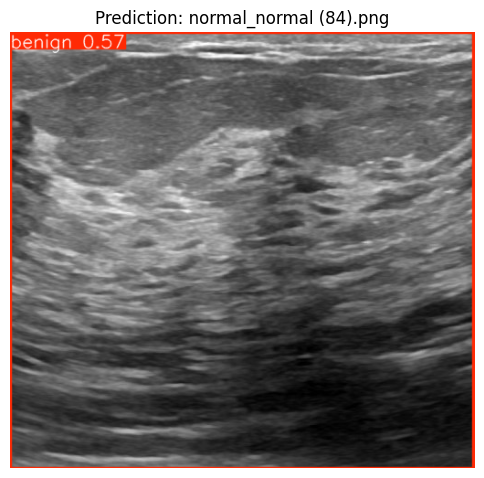


image 1/1 /kaggle/working/images/val/benign_benign (15).png: 480x640 1 benign, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


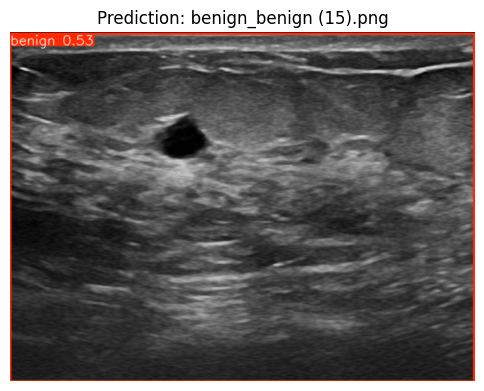


image 1/1 /kaggle/working/images/val/benign_benign (64).png: 512x640 1 benign, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


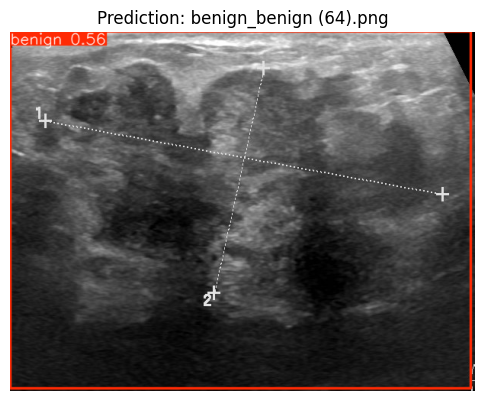


image 1/1 /kaggle/working/images/val/malignant_malignant (85).png: 448x640 1 benign, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


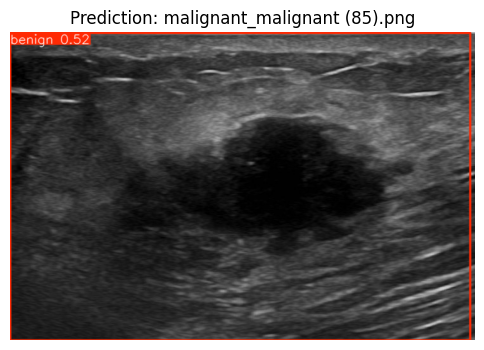


image 1/1 /kaggle/working/images/val/normal_normal (87).png: 544x640 1 benign, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


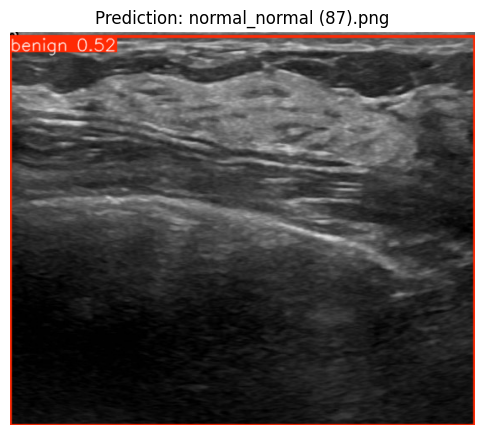


image 1/1 /kaggle/working/images/val/benign_benign (380).png: 512x640 1 benign, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


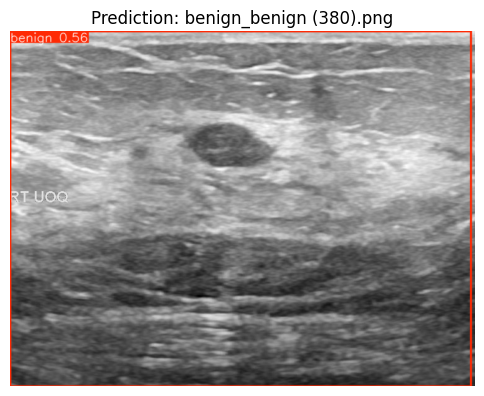


image 1/1 /kaggle/working/images/val/benign_benign (268).png: 448x640 1 benign, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


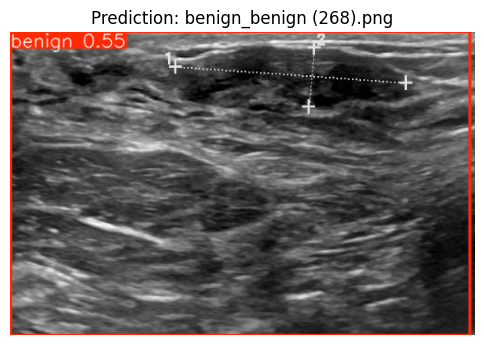


image 1/1 /kaggle/working/images/val/benign_benign (155).png: 480x640 1 benign, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


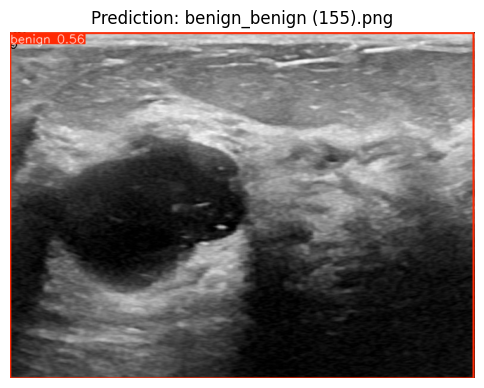


image 1/1 /kaggle/working/images/val/benign_benign (310).png: 576x640 1 benign, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


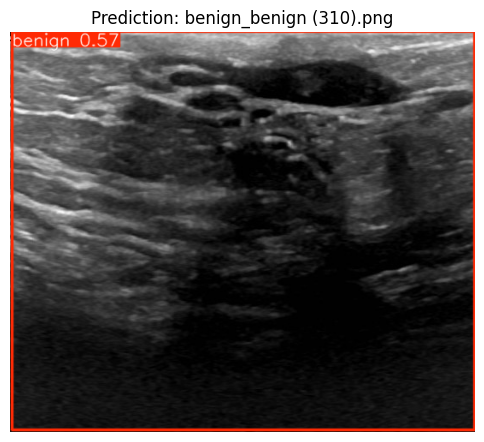


image 1/1 /kaggle/working/images/val/benign_benign (117).png: 576x640 1 benign, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


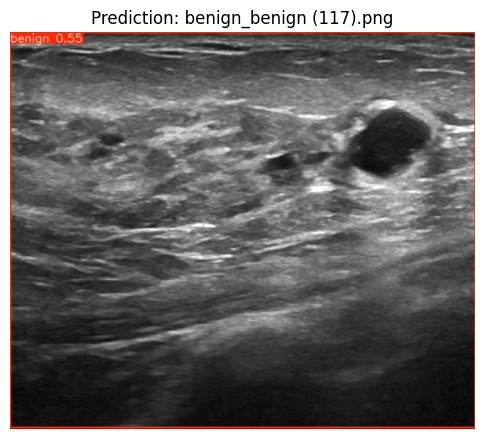

In [17]:
# Procesare + salvare
for img_name in random_images:
    img_path = os.path.join(val_dir, img_name)
    
    # Rulează predicția
    results = model.predict(source=img_path, conf=0.25, save=False, show=False)

    # Imagine cu bounding boxes desenate
    im_with_boxes = results[0].plot()

    # Afișare în notebook
    plt.figure(figsize=(6, 6))
    plt.imshow(im_with_boxes)
    plt.axis("off")
    plt.title(f"Prediction: {img_name}")
    plt.show()

    # Salvare imagine cu predicții
    save_path = os.path.join(save_dir, f"pred_{img_name}")
    Image.fromarray(im_with_boxes).save(save_path)

In [18]:
from IPython.display import Image, display

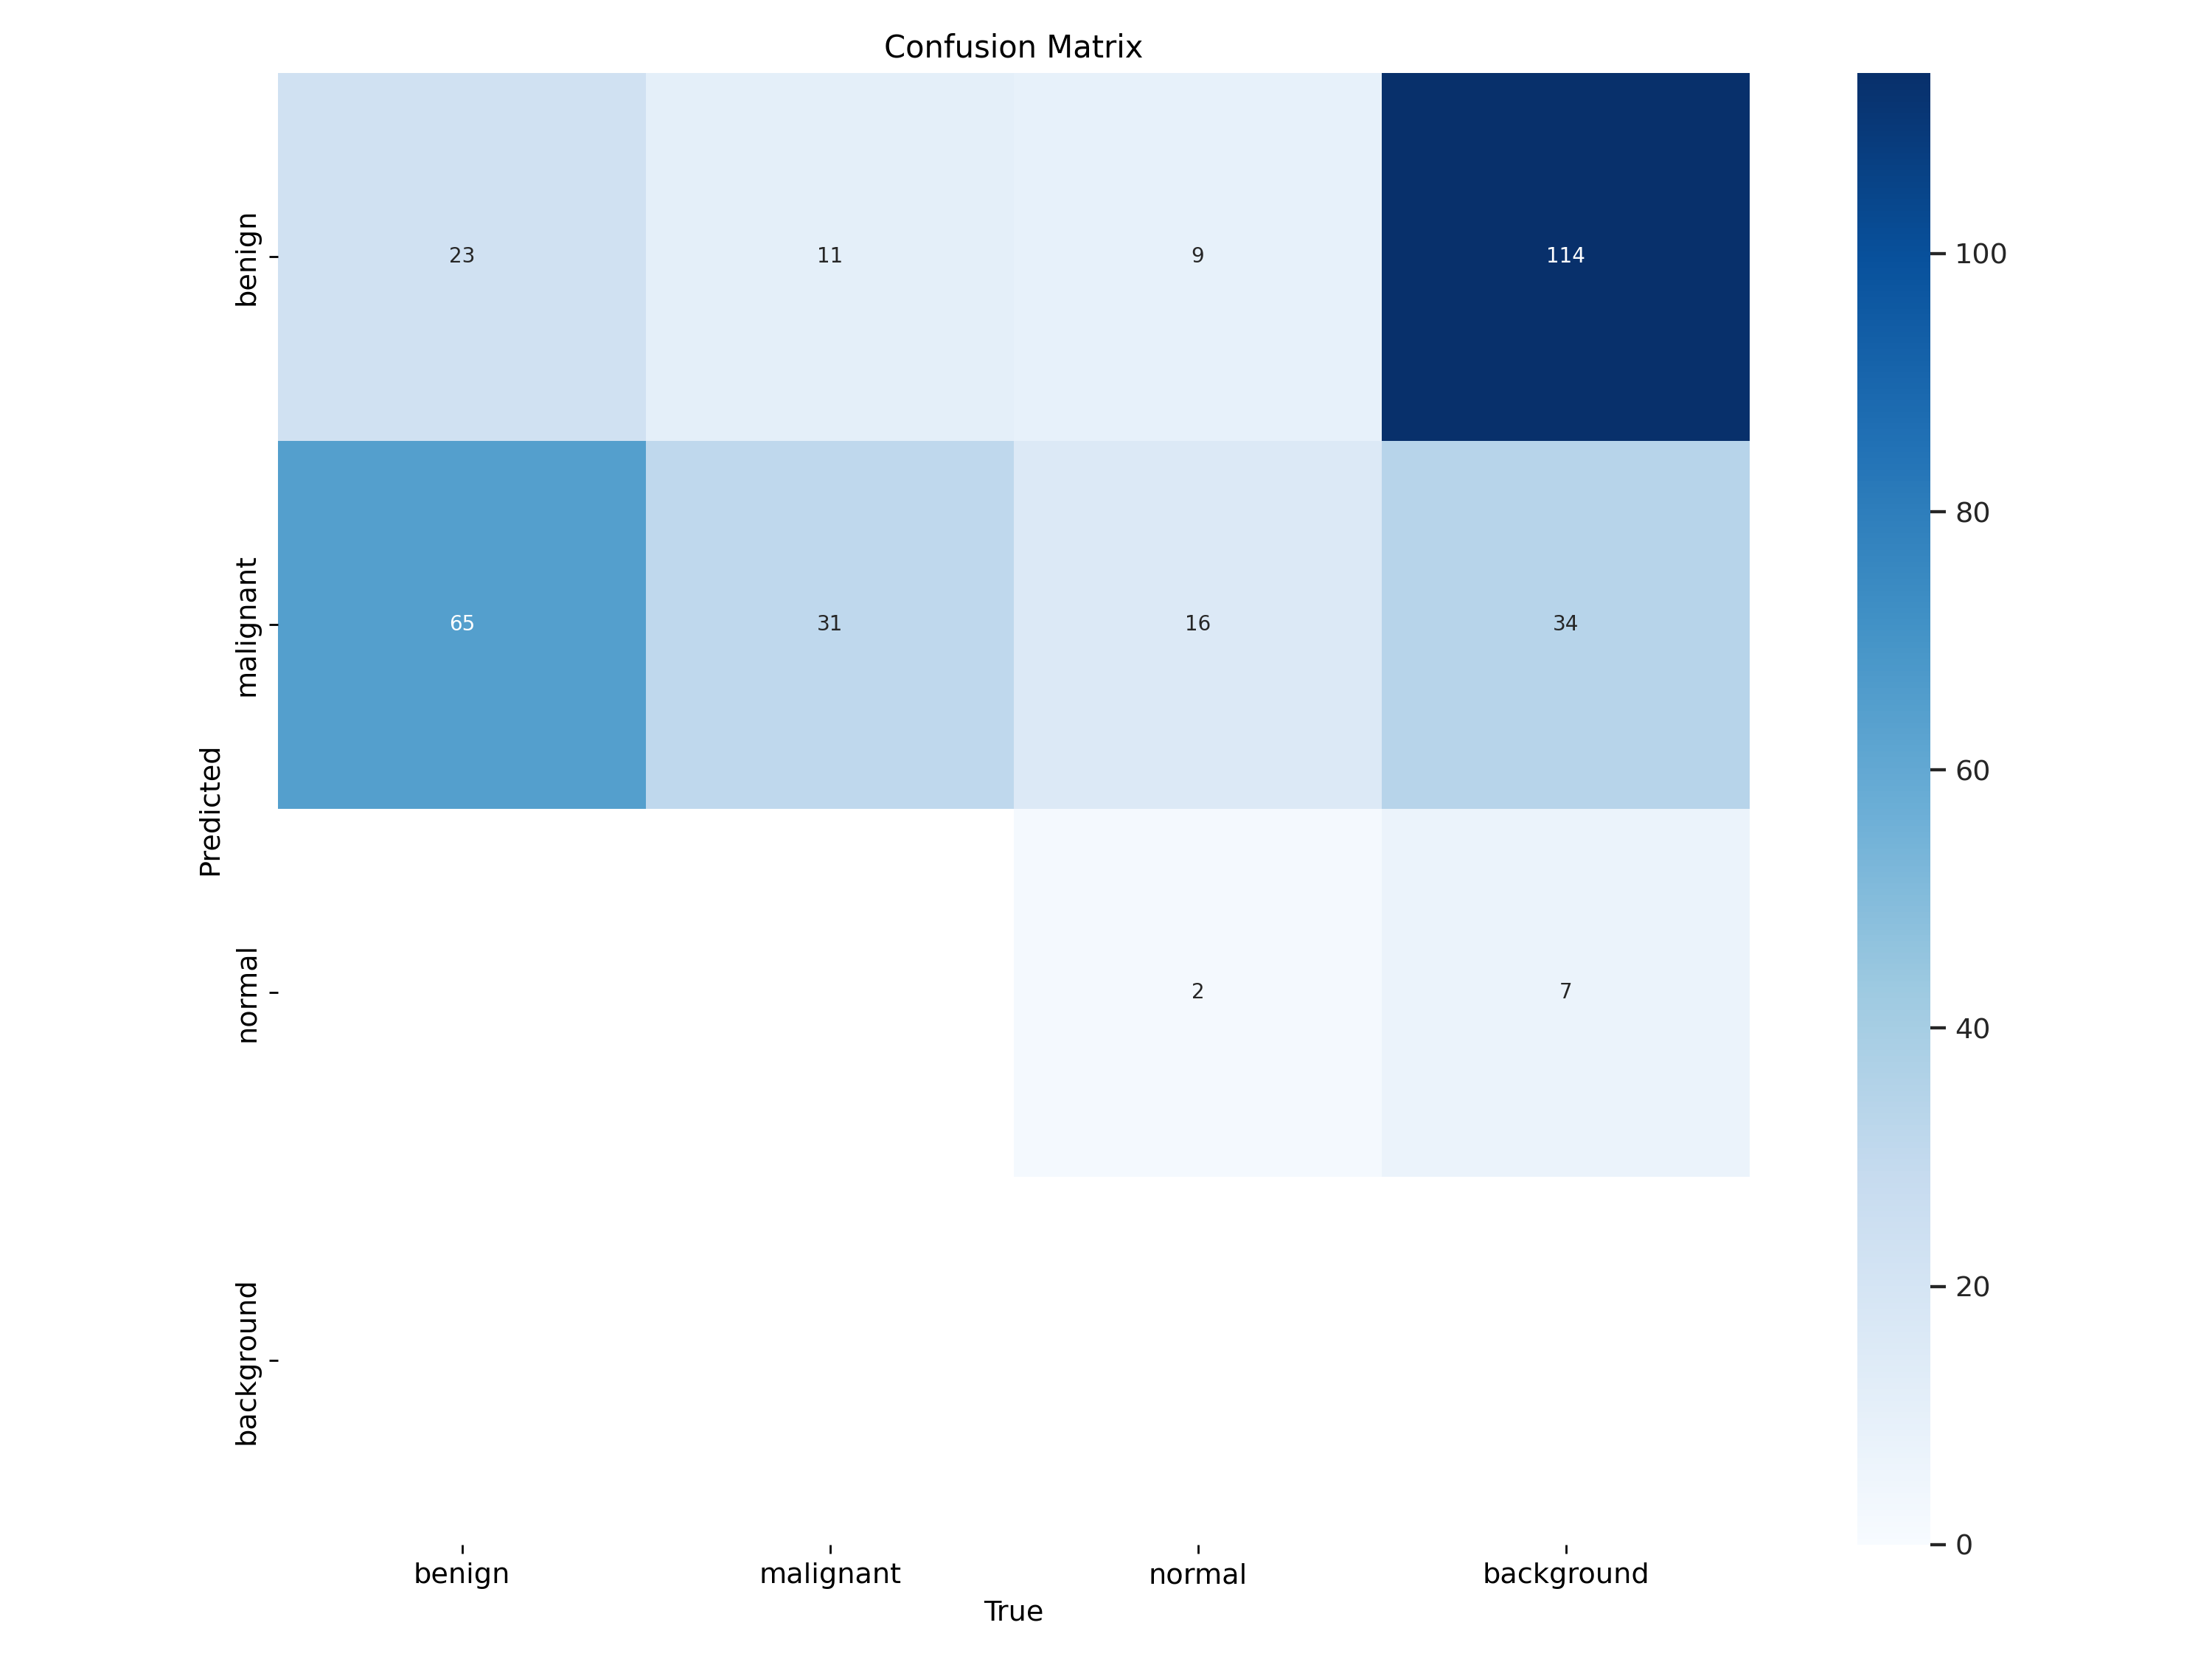

In [24]:
# Afișează matricea de confuzieimport pandas as pd
display(Image(filename="runs/detect/breast_ultrasound_model/confusion_matrix.png"))

In [20]:
import pandas as pd

In [21]:
# Încarcă log-ul de antrenare salvat de YOLOv8
log_path = "runs/detect/breast_ultrasound_model/results.csv"
df = pd.read_csv(log_path)

In [25]:
df = pd.read_csv("runs/detect/breast_ultrasound_model/results.csv")
print(df.columns.tolist())  # vezi toate coloanele disponibile
df.head()  # vezi primele 5 rânduri

['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,11.6812,2.86456,3.48733,4.07045,0.00512,1.00000,0.22228,0.06824,2.27140,2.96886,3.84480,0.000470,0.000470,0.000470
1,2,20.8495,2.46965,3.17343,3.48231,0.00540,1.00000,0.06697,0.02598,2.23212,2.92000,4.07896,0.000900,0.000900,0.000900
2,3,29.8051,2.13854,2.96939,2.95303,0.14588,0.32244,0.16593,0.07962,2.19842,4.01846,2.96688,0.001282,0.001282,0.001282
3,4,38.7612,1.89939,2.79029,2.63334,0.50607,0.26515,0.32875,0.24916,1.36547,2.50739,2.27725,0.001217,0.001217,0.001217
4,5,47.9774,1.63316,2.58581,2.35889,0.17999,0.43001,0.26667,0.21276,1.10976,2.45086,2.00512,0.001146,0.001146,0.001146


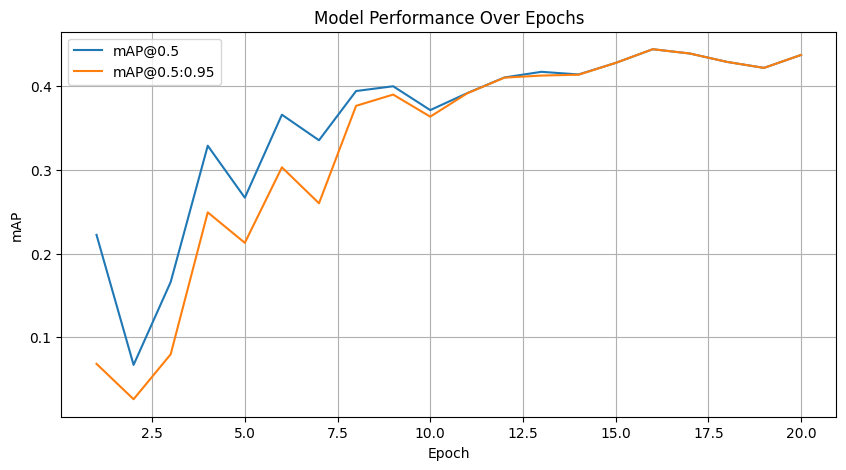

In [26]:
plt.figure(figsize=(10,5))
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Model Performance Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
preds = sum(len(model.predict(os.path.join("images/val", f))[0].boxes) 
            for f in os.listdir("images/val") if f.endswith(".png"))
print(f"Total predicted objects: {preds}")


image 1/1 /kaggle/working/images/val/benign_benign (386).png: 512x640 1 benign, 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /kaggle/working/images/val/benign_benign (355).png: 544x640 1 benign, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /kaggle/working/images/val/benign_benign (392).png: 448x640 1 benign, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/images/val/benign_benign (176).png: 448x640 1 benign, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/images/val/malignant_malignant (12).png: 544x640 1 benign, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /kaggle/working/images/val/benign_benign (404).png: 480x640 1 benign,

In [29]:
import os

print(os.listdir("runs/detect/"))
print(os.listdir("runs/detect/breast_ultrasound_model"))  # sau alt nume dacă e diferit

['breast_ultrasound_model', 'breast_ultrasound_model2', 'breast_ultrasound_model3']
['labels.jpg', 'train_batch2.jpg', 'val_batch1_labels.jpg', 'train_batch781.jpg', 'P_curve.png', 'weights', 'val_batch1_pred.jpg', 'results.csv', 'train_batch780.jpg', 'F1_curve.png', 'confusion_matrix_normalized.png', 'val_batch2_labels.jpg', 'val_batch2_pred.jpg', 'R_curve.png', 'results.png', 'train_batch782.jpg', 'train_batch1.jpg', 'confusion_matrix.png', 'val_batch0_labels.jpg', 'train_batch0.jpg', 'labels_correlogram.jpg', 'args.yaml', 'val_batch0_pred.jpg', 'PR_curve.png']


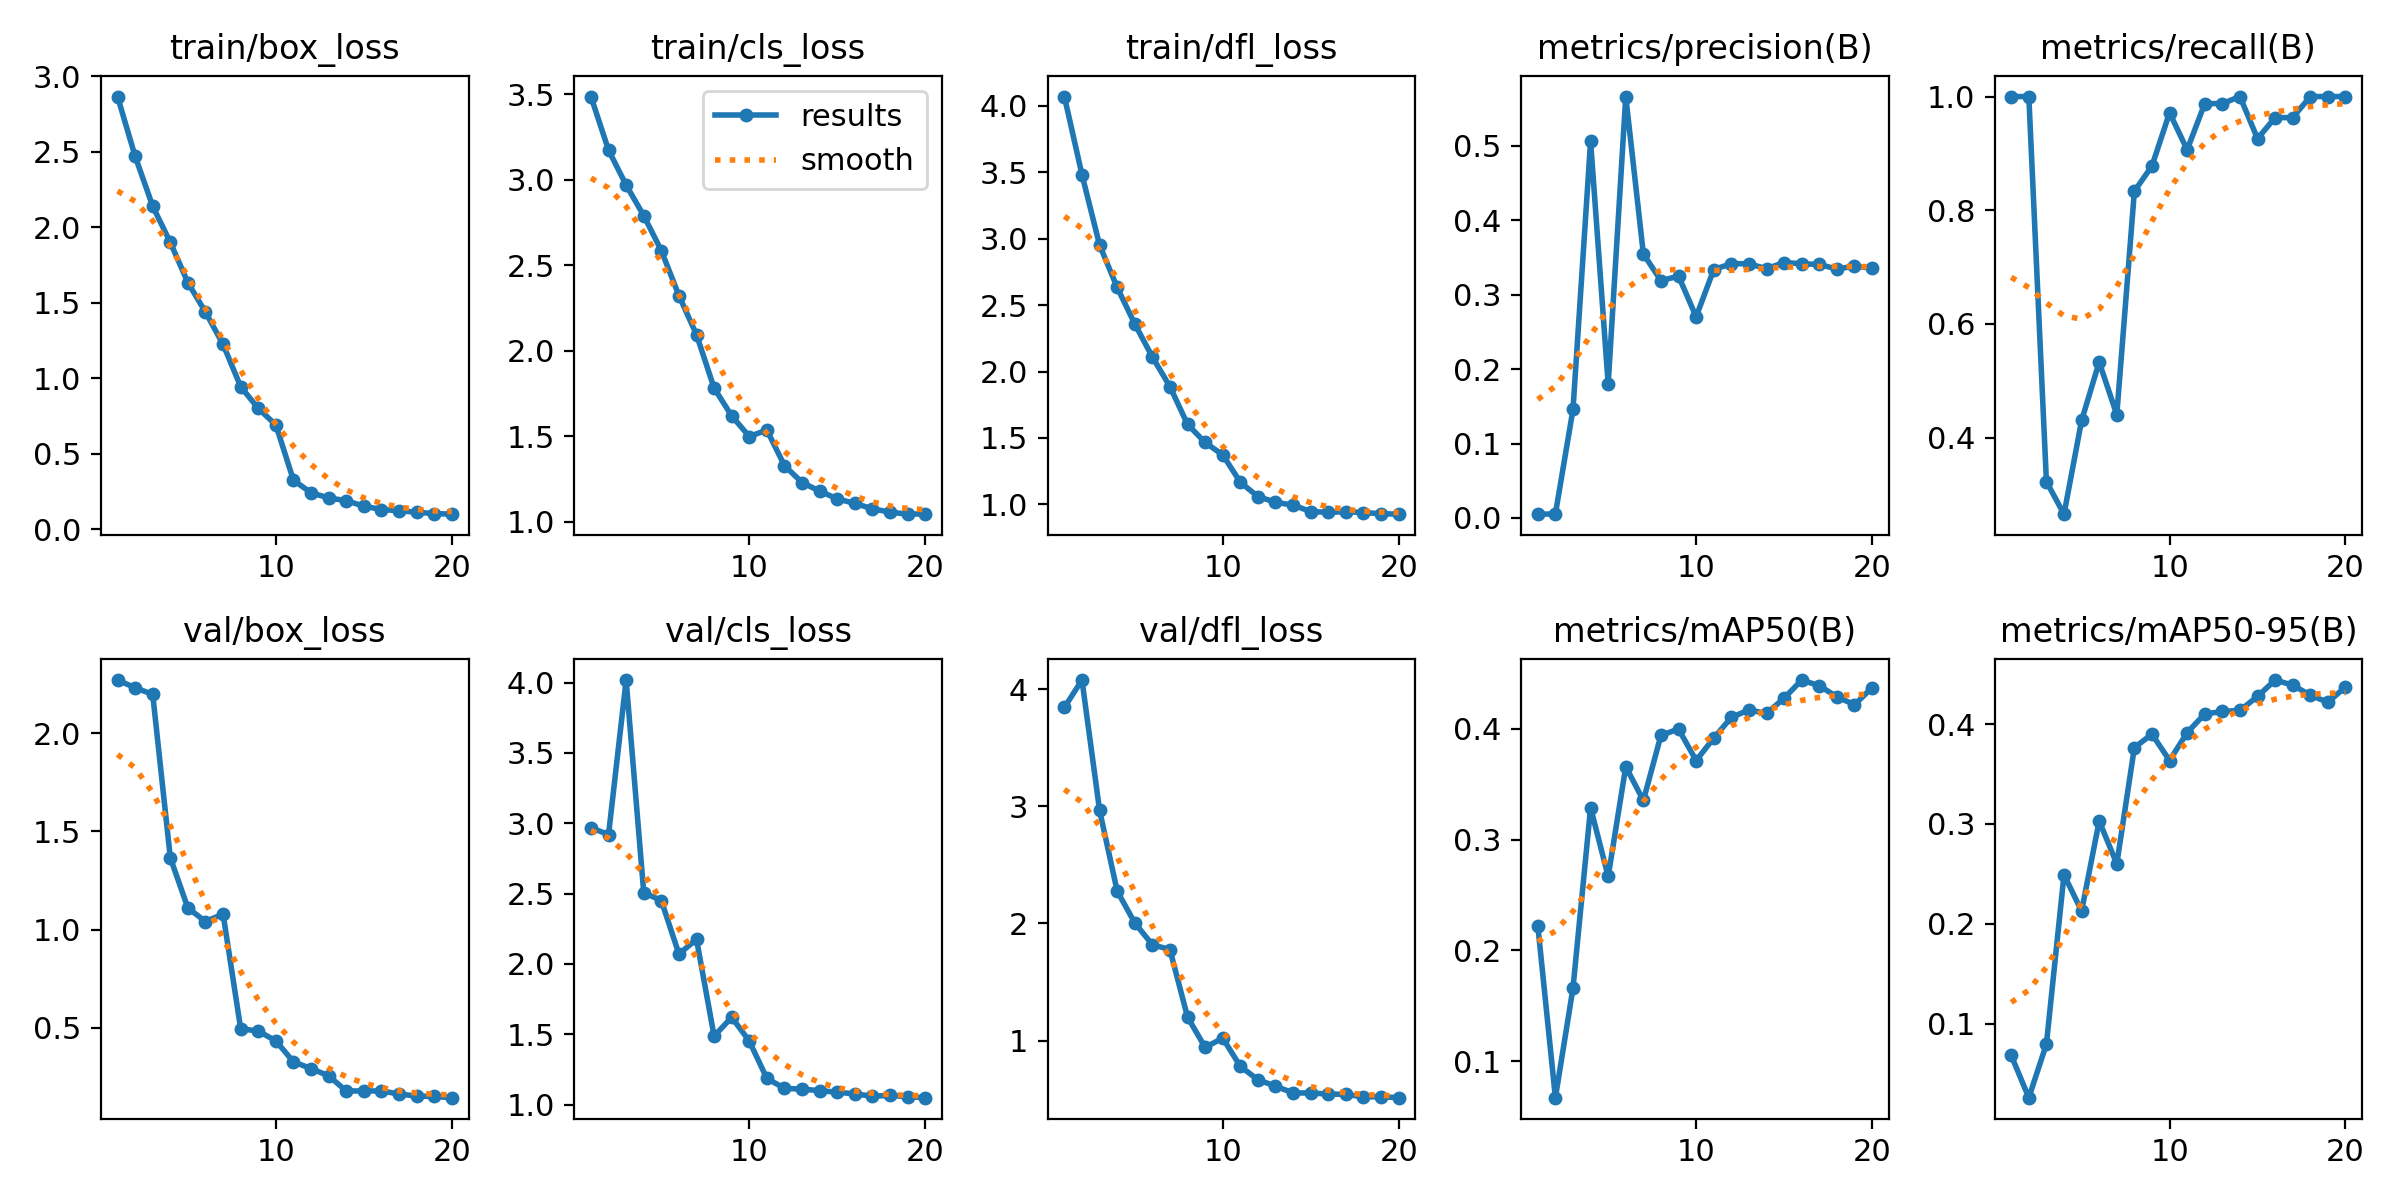

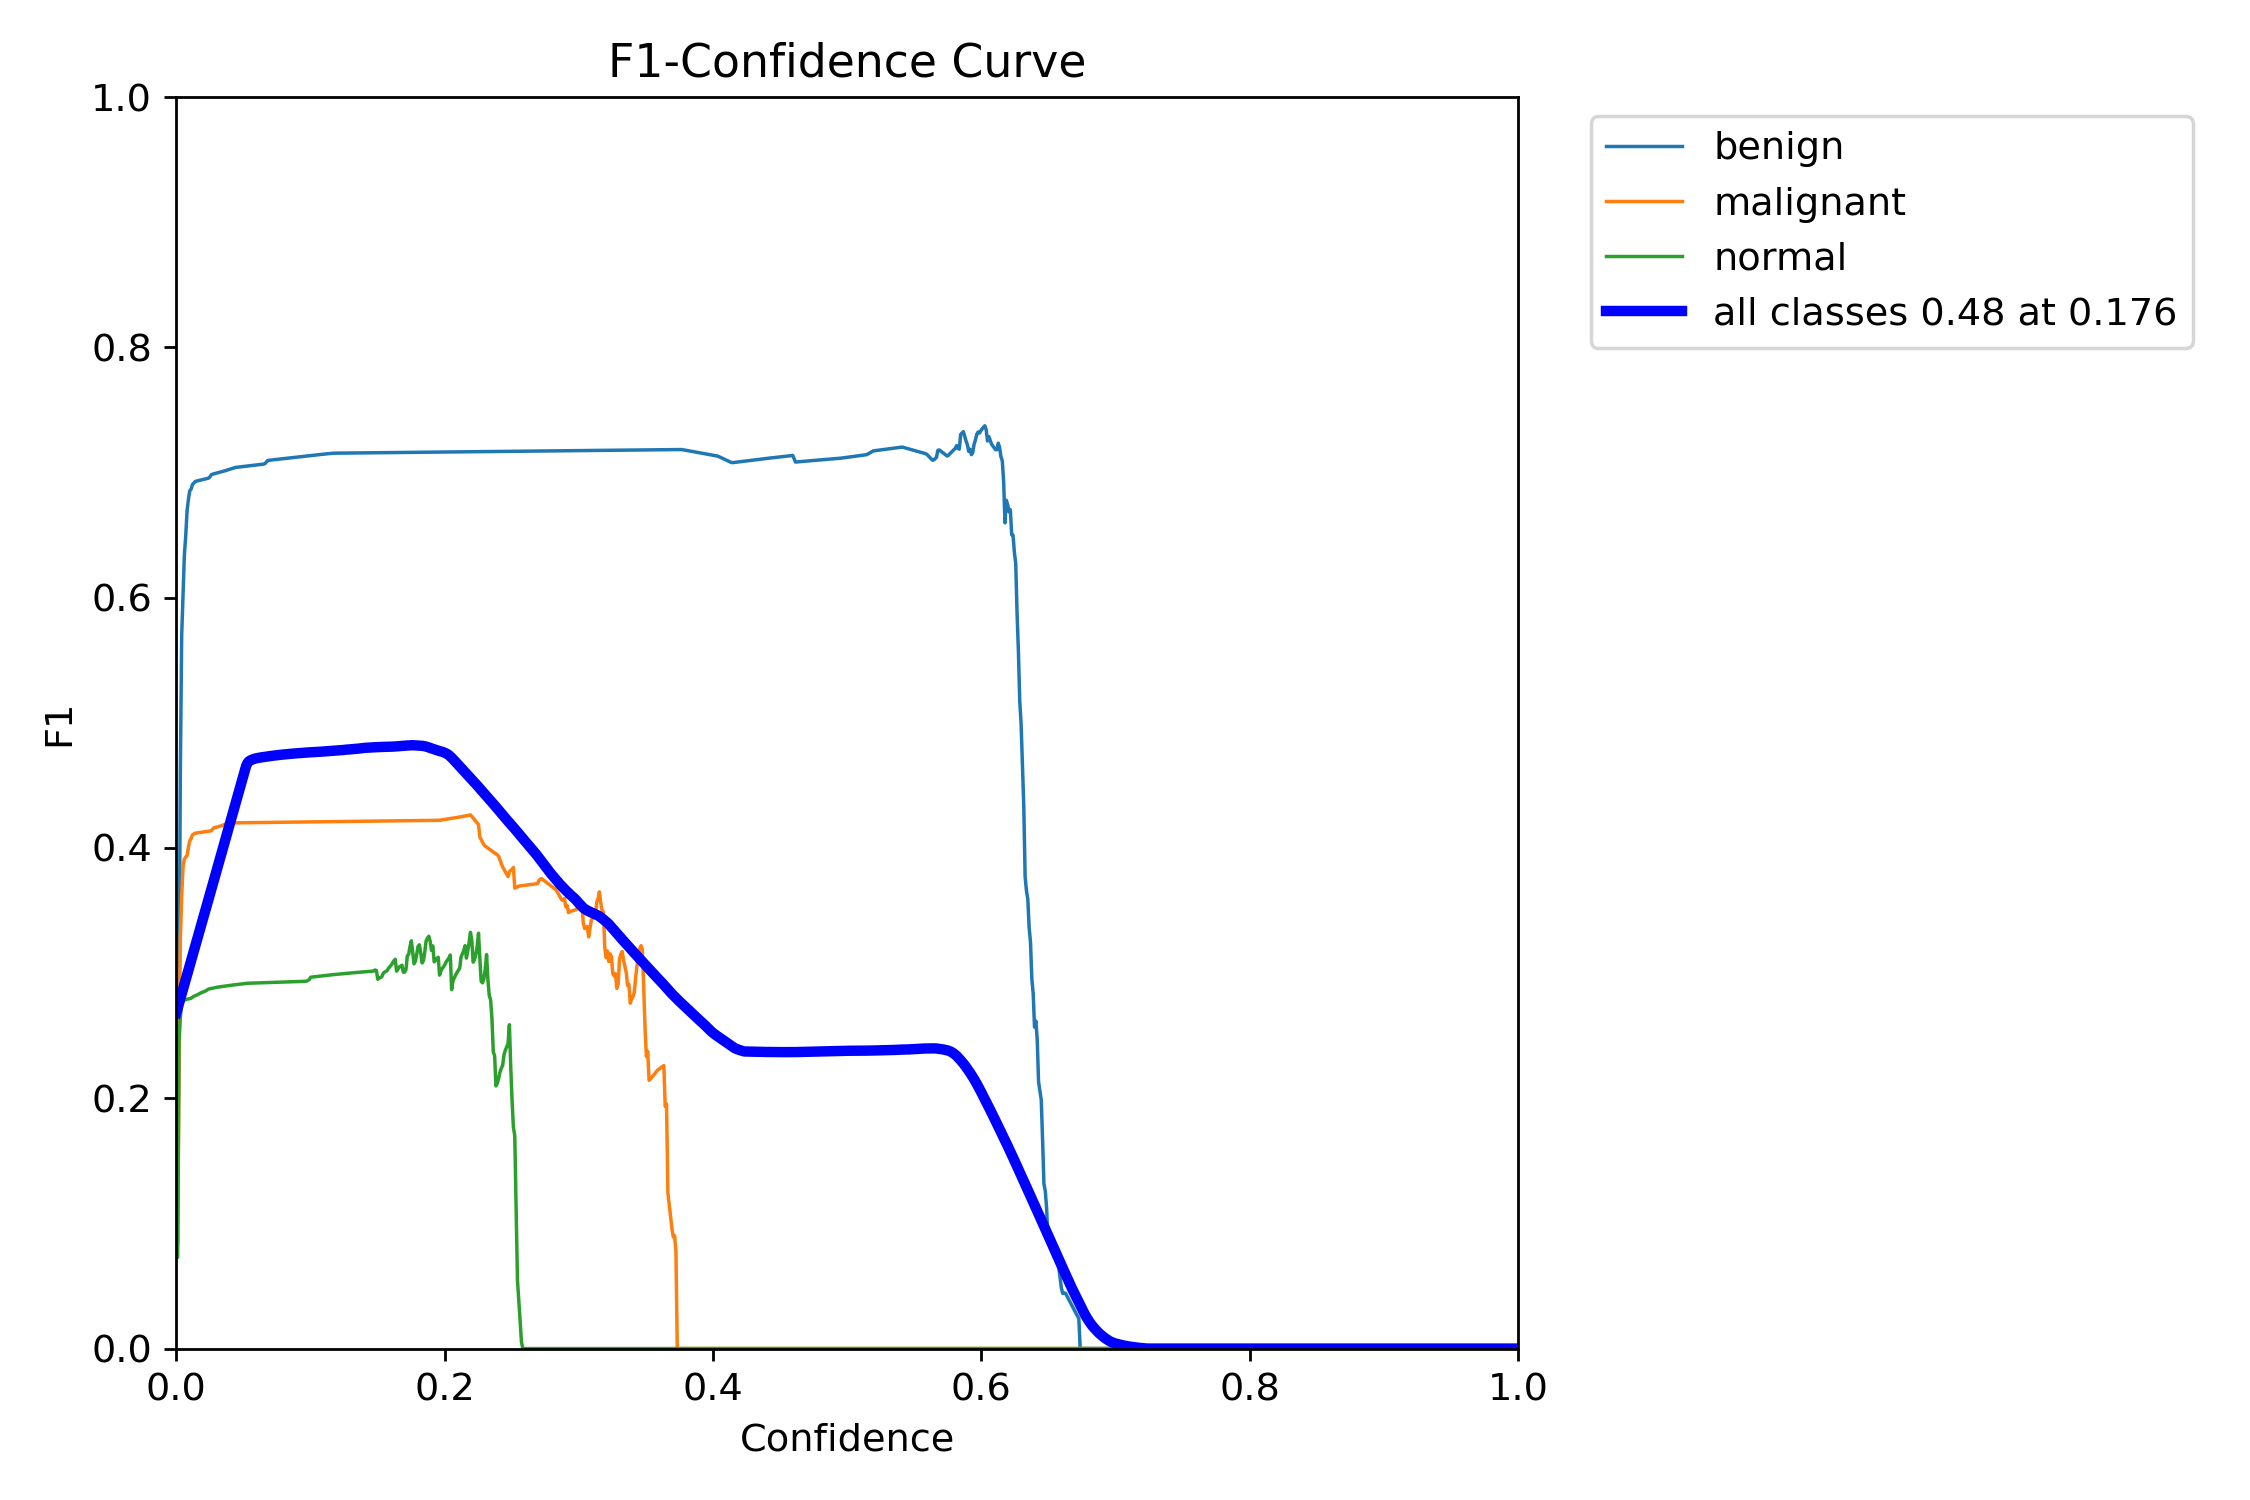

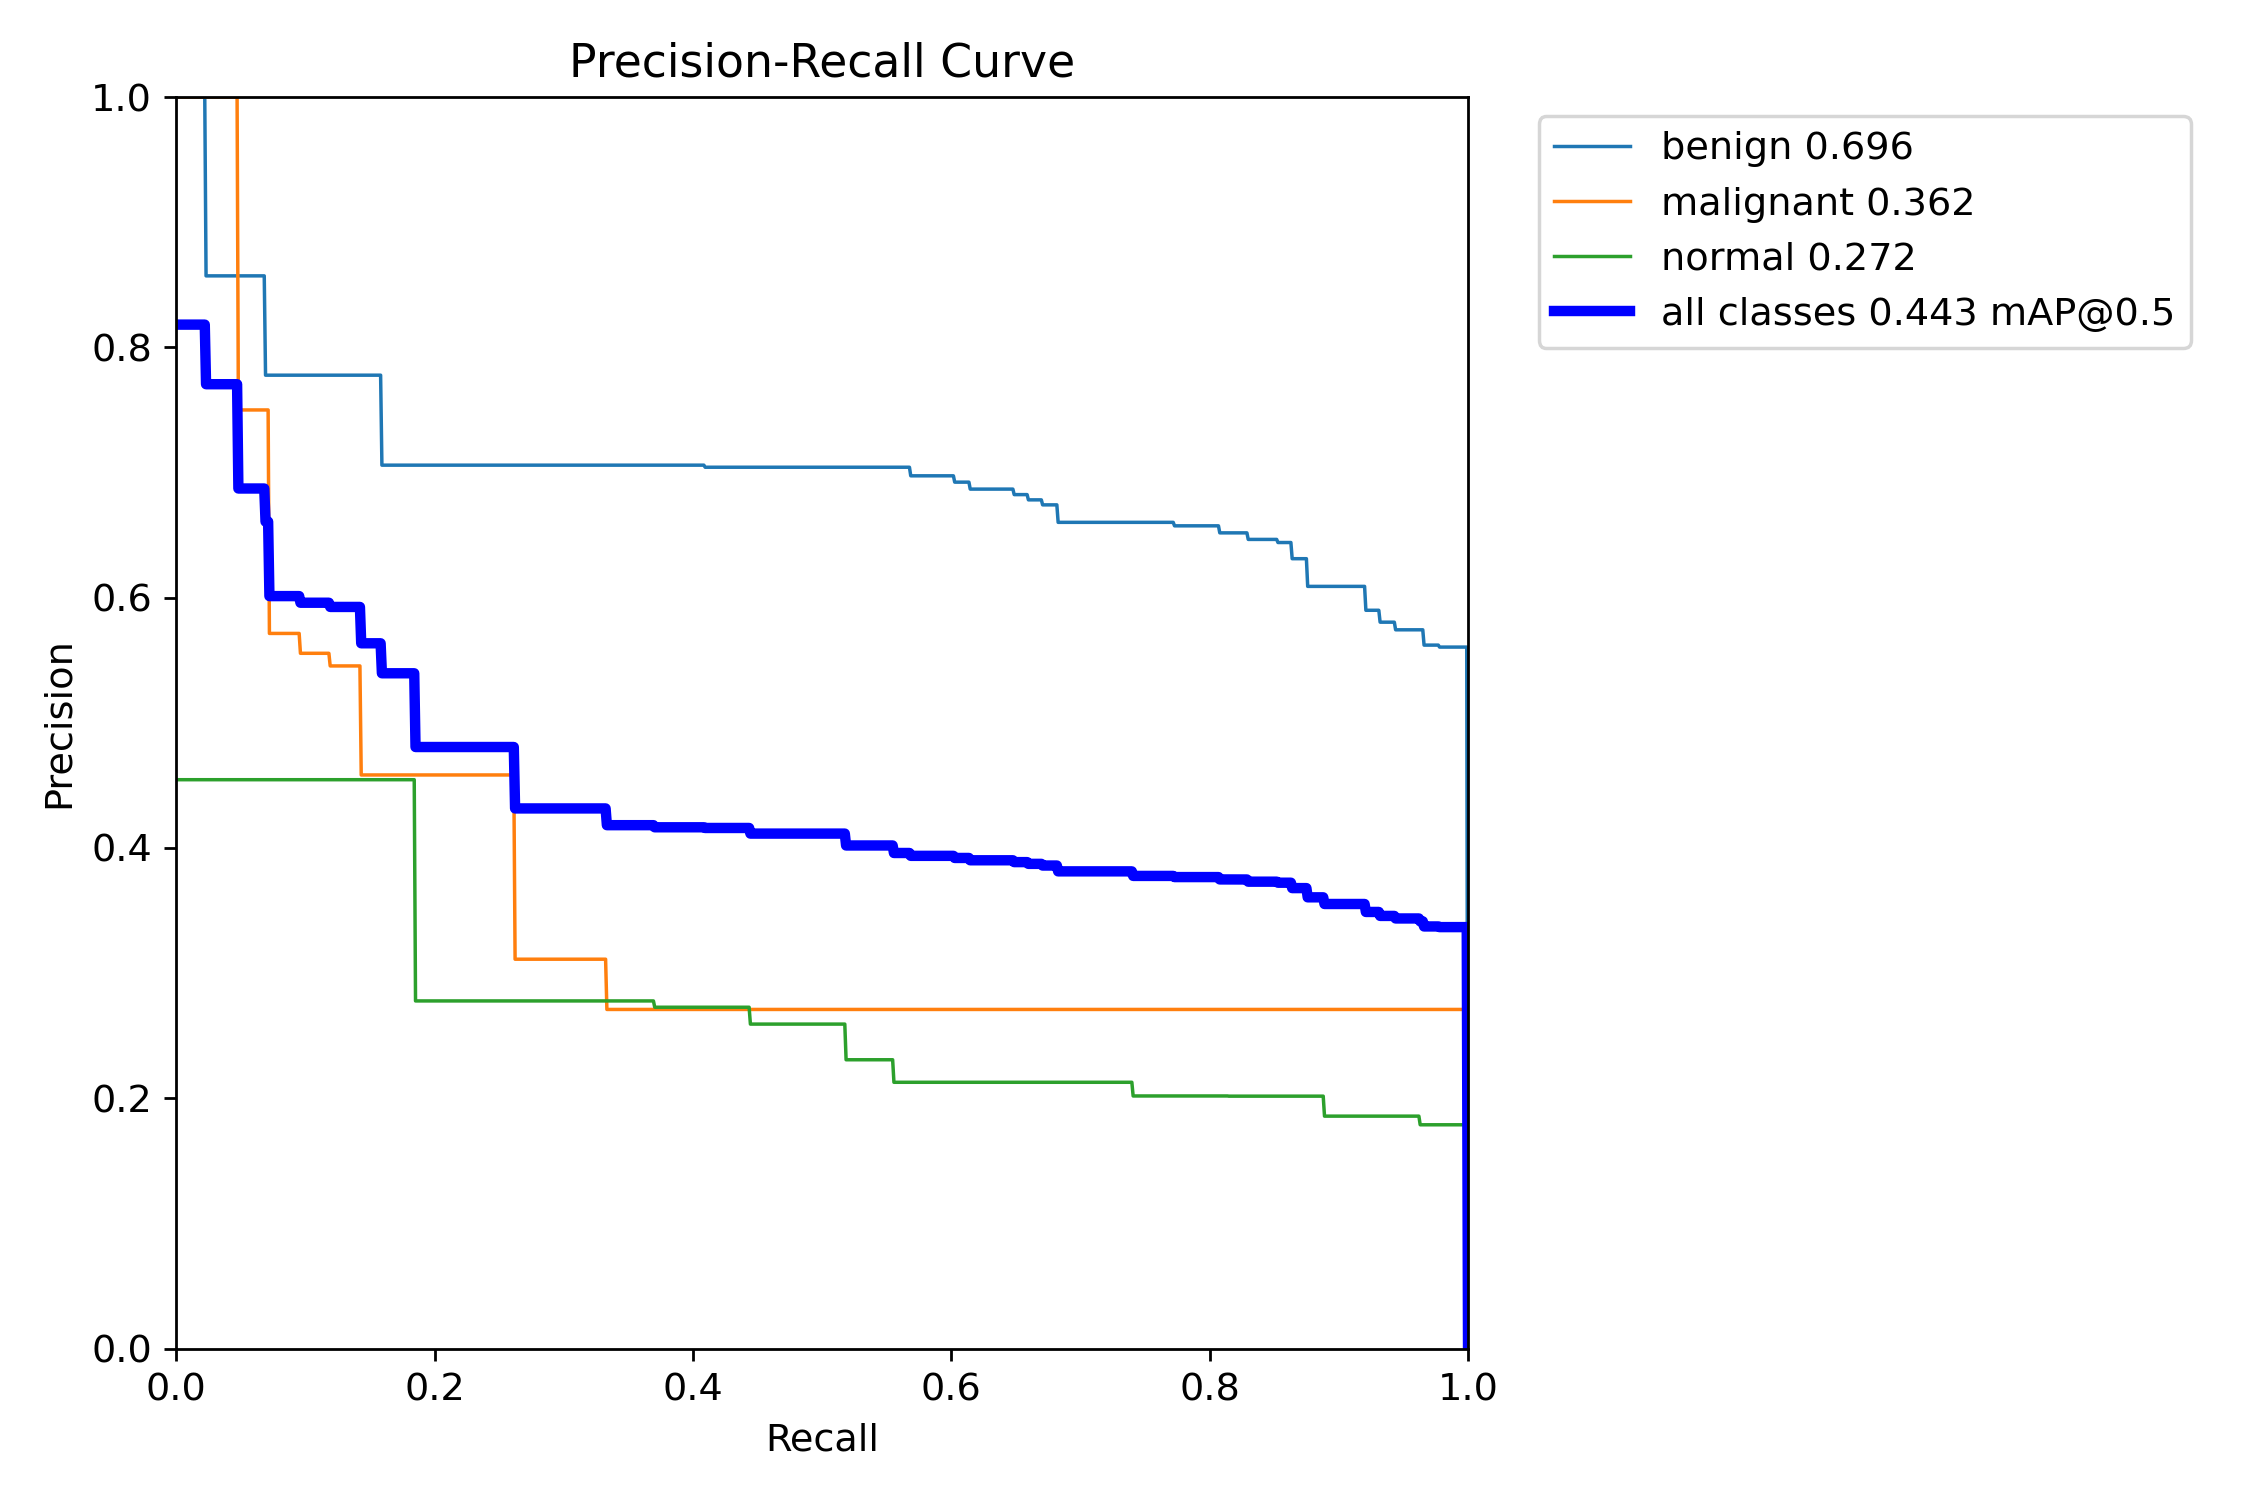

In [32]:
from IPython.display import Image, display

# Afișează graficele relevante
display(Image(filename="runs/detect/breast_ultrasound_model/results.png"))
display(Image(filename="runs/detect/breast_ultrasound_model/F1_curve.png"))
display(Image(filename="runs/detect/breast_ultrasound_model/PR_curve.png"))